In [5]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve
)   

In [6]:
DATA_PATH = Path("creditcard.csv")  
df = pd.read_csv(DATA_PATH)

In [7]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [ ]:
# -- 'Time' is seconds from the first transaction; it may capture daily or weekly transaction patterns.
# -- 'V1'-'V28' Anonymized features created with PCA; original meanings are not disclosed but they carry important information.
# -- 'Amount' is raw transaction value and strongly right-skewed; it is informative but must be controlled for scale/outliers.
# -- 'Class' is our label: 0 = normal, 1 = fraud. Very imbalanced, so metrics like recall matter more than accuracy.
before = len(df)
df = df.drop_duplicates()
print(f"[Cleaning] Duplicates removed: {before - len(df)}")

[Cleaning] Duplicates removed: 1081


In [23]:
# -- Split off the labels after cleaning, so y always matches the rows in X
assert "Class" in df.columns, "Expect a target column named 'Class'."
y = df["Class"].astype(int)
X = df.drop(columns=["Class"])

In [ ]:
# -- KNN is distance-based. If 'Amount' is huge, it can overshadow the other features.
# -- IQR clipping keeps the overall pattern while taming extreme values.
def iqr_clip(series, k=1.5):
    q1, q3 = np.percentile(series, [25, 75])
    iqr = q3 - q1
    low, high = q1 - k * iqr, q3 + k * iqr
    return np.clip(series, low, high)

if "Amount" in X.columns:
    X["Amount"] = iqr_clip(X["Amount"], k=1.5)

In [ ]:
# Train/test split — keep the original class imbalance in TEST to reflect real-world prevalence.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print(f"[Split] Train={len(y_train)}, Test={len(y_test)}, Test fraud rate={y_test.mean():.4%}")

[Split] Train=226980, Test=56746, Test fraud rate=0.1674%


In [7]:
#  - Median is robust for long-tailed numeric features like 'Amount'.
#  - KNN MUST be scaled (StandardScaler) so 'Amount'/'Time' won't dominate distance.
num_cols = X_train.columns.tolist()
num_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
pre = ColumnTransformer([
    ("num", num_pre, num_cols)
], remainder="drop")

In [ ]:
# -- Imbalance handling for training only, light undersampling to stabilize KNN runtime and improve minority neighborhood quality.
fraud_idx = y_train[y_train == 1].index
nonfraud_idx = y_train[y_train == 0].index
rng = np.random.default_rng(42)
nonfraud_sample = rng.choice(nonfraud_idx, size=min(len(nonfraud_idx), 3 * len(fraud_idx)), replace=False)
sel_idx = np.concatenate([fraud_idx.values, nonfraud_sample])
X_train_bal = X_train.loc[sel_idx]
y_train_bal = y_train.loc[sel_idx]
print(f"[Balance] TRAIN balanced size={len(y_train_bal)} | fraud={y_train_bal.sum()} | nonfraud={len(y_train_bal)-y_train_bal.sum()}")

[Balance] TRAIN balanced size=1512 | fraud=378 | nonfraud=1134


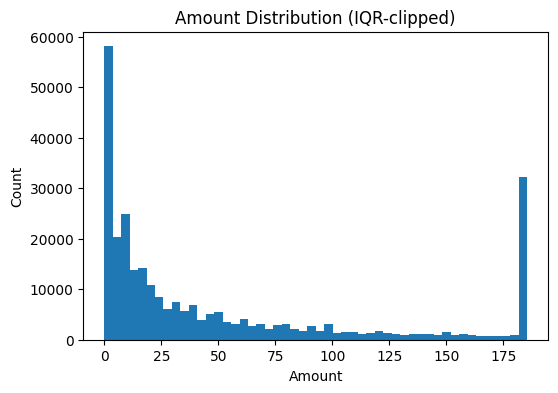

In [ ]:
# -- Look at the distribution of 'Amount'. It still shows a right-skew with a long tail.
plt.figure(figsize=(6,4))
plt.hist(X["Amount"], bins=50)
plt.xlabel("Amount"); plt.ylabel("Count"); plt.title("Amount Distribution (IQR-clipped)")
plt.show()

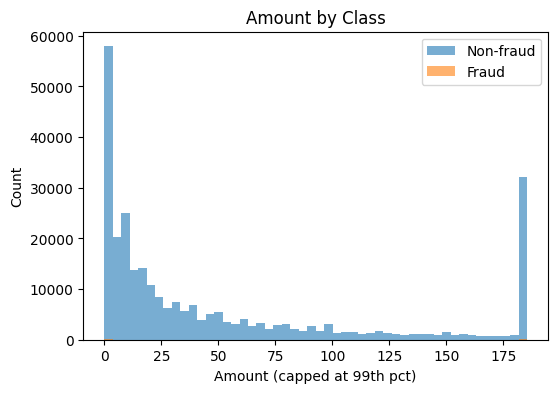

In [ ]:
# -- Insight: raw 'Amount' alone is not decisive; its interaction with PCA components matters more.
q = X["Amount"].quantile(0.99)
plt.figure(figsize=(6,4))
plt.hist(X.loc[y==0, "Amount"].clip(upper=q), bins=50, alpha=0.6, label="Non-fraud")
plt.hist(X.loc[y==1, "Amount"].clip(upper=q), bins=50, alpha=0.6, label="Fraud")
plt.xlabel("Amount (capped at 99th pct)"); plt.ylabel("Count"); plt.title("Amount by Class")
plt.legend(); plt.show()

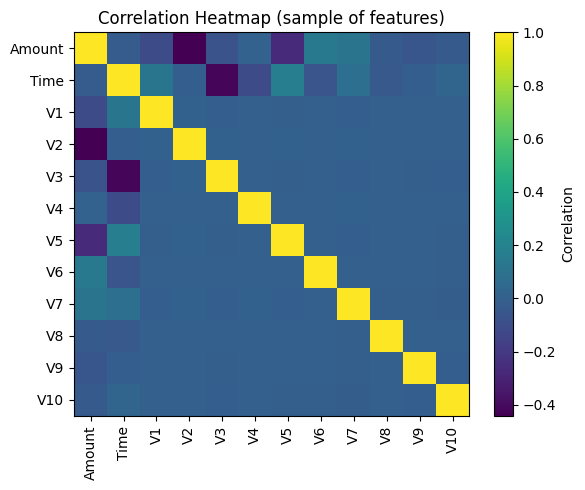

In [ ]:
# -- Correlation heatmap among a small subset (to be readable); PCA components are largely uncorrelated by design.
subset_cols = ["Amount", "Time"] + [c for c in X.columns if c.startswith("V")][:10]
corr = pd.DataFrame(X[subset_cols]).corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap="viridis", aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(subset_cols)), subset_cols, rotation=90)
plt.yticks(range(len(subset_cols)), subset_cols)
plt.title("Correlation Heatmap (sample of features)")
plt.tight_layout(); plt.show()

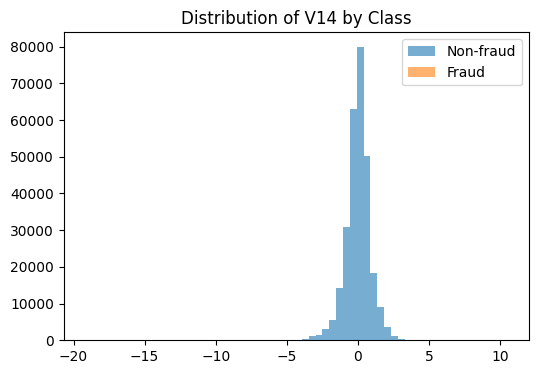

In [ ]:
# -- PCA component shift check (example: distribution of V14 vs class) — subtle but informative shifts.
if "V14" in X.columns:
    plt.figure(figsize=(6,4))
    plt.hist(X.loc[y==0, "V14"], bins=60, alpha=0.6, label="Non-fraud")
    plt.hist(X.loc[y==1, "V14"], bins=60, alpha=0.6, label="Fraud")
    plt.title("Distribution of V14 by Class")
    plt.legend(); plt.show()

In [ ]:
# -- Modeling — KNN with scaling & optional PCA
use_pca = True
steps = [("pre", pre)]
if use_pca:
    steps.append(("pca", PCA(n_components=0.95, svd_solver="full", random_state=42)))
steps.append(("knn", KNeighborsClassifier()))
pipe = Pipeline(steps)

In [ ]:
# -- n_neighbors -> bias-variance tradeoff (small k risks overfitting fraud; large k may miss rare patterns)
# -- weights='distance' lets closer neighbors dominate (intuitive for fraud proximity)
# -- p=2 Euclidean; p=1 Manhattan could be added if needed
param_grid = {
    "knn__n_neighbors": [5, 15, 25],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [2]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid=param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=0)

In [ ]:
# -- Fit on BALANCED train; evaluate on original TEST (keeps real-world class ratio)
gs.fit(X_train_bal, y_train_bal)
print("[Model] Best params:", gs.best_params_)
best_model = gs.best_estimator_

[Model] Best params: {'knn__n_neighbors': 25, 'knn__p': 2, 'knn__weights': 'distance'}


In [ ]:
# -- Evaluation — show metrics & plots directly (no saving)
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_prob)
pr_auc  = average_precision_score(y_test, y_prob)

In [ ]:
# -- Metrics table — directly display instead of saving
metrics_df = pd.DataFrame({
    "ROC_AUC":[roc_auc],
    "PR_AUC":[pr_auc],
    "Best_Params":[str(gs.best_params_)],
    "Train_Balanced_Size":[len(y_train_bal)],
    "Test_Size":[len(y_test)]
})
print("\n=== Metrics (original imbalanced TEST) ===")
print(metrics_df, "\n")

print("=== Classification report (threshold=0.5) ===")
print(classification_report(y_test, y_pred, digits=4))
print("=== Confusion matrix (threshold=0.5) ===")
print(confusion_matrix(y_test, y_pred))


=== Metrics (original imbalanced TEST) ===
   ROC_AUC    PR_AUC                                        Best_Params  \
0  0.94589  0.686992  {'knn__n_neighbors': 25, 'knn__p': 2, 'knn__we...   

   Train_Balanced_Size  Test_Size  
0                 1512      56746   

=== Classification report (threshold=0.5) ===
              precision    recall  f1-score   support

           0     0.9996    0.9985    0.9991     56651
           1     0.4650    0.7684    0.5794        95

    accuracy                         0.9981     56746
   macro avg     0.7323    0.8835    0.7892     56746
weighted avg     0.9987    0.9981    0.9984     56746

=== Confusion matrix (threshold=0.5) ===
[[56567    84]
 [   22    73]]


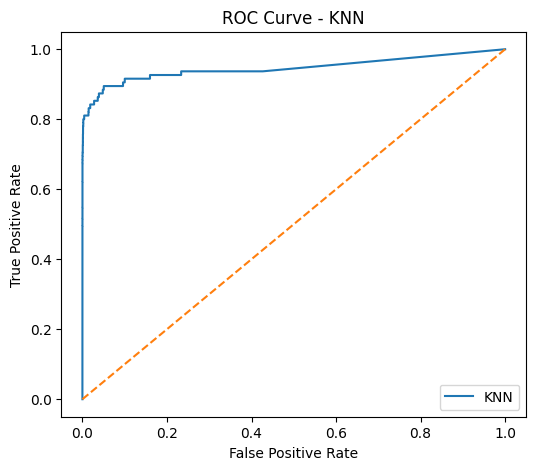

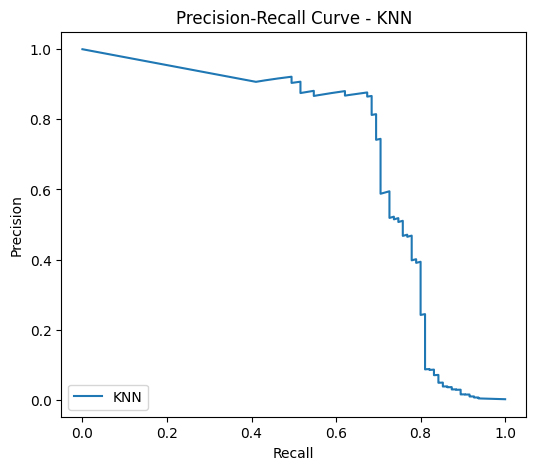

In [ ]:
# -- ROC curve — displayed
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="KNN")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KNN"); plt.legend(loc="lower right")
plt.show()

# -- PR curve — displayed
prec, rec, thr = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label="KNN")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve - KNN"); plt.legend(loc="lower left")
plt.show()

In [ ]:
# -- Threshold tuning — (i) best F1 and (ii) target recall example (e.g., 0.90)
def pick_threshold_for_best_f1(y_true, y_score):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    thr = np.append(thr, 1.0)
    f1 = 2*(prec*rec)/(prec+rec+1e-12)
    i = np.nanargmax(f1)
    return float(thr[i]), float(f1[i]), float(prec[i]), float(rec[i])

best_thr, best_f1, best_p, best_r = pick_threshold_for_best_f1(y_test, y_prob)
print(f"\n[F1-opt] threshold={best_thr:.4f} | F1={best_f1:.4f} | Precision={best_p:.4f} | Recall={best_r:.4f}")

y_pred_f1 = (y_prob >= best_thr).astype(int)
print("\n=== Report @F1-opt threshold ===")
print(classification_report(y_test, y_pred_f1, digits=4))
print("=== Confusion matrix @F1-opt ===")
print(confusion_matrix(y_test, y_pred_f1))

def pick_threshold_for_target_recall(y_true, y_score, target_recall=0.90):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    thr = np.append(thr, 1.0)
    idx = np.where(rec >= target_recall)[0]
    if len(idx) == 0:
        return float(thr[-1]), float(rec[-1]), float(prec[-1])
    i = idx[0]
    return float(thr[i]), float(rec[i]), float(prec[i])

thr_r90, r90, p_at_r90 = pick_threshold_for_target_recall(y_test, y_prob, 0.90)
print(f"\n[Recall>=0.90] threshold={thr_r90:.4f} | Recall={r90:.4f} | Precision={p_at_r90:.4f}")
print("=== Confusion matrix @Recall>=0.90 ===")
print(confusion_matrix(y_test, (y_prob >= thr_r90).astype(int)))


[F1-opt] threshold=0.8163 | F1=0.7647 | Precision=0.8667 | Recall=0.6842

=== Report @F1-opt threshold ===
              precision    recall  f1-score   support

           0     0.9995    0.9998    0.9996     56651
           1     0.8667    0.6842    0.7647        95

    accuracy                         0.9993     56746
   macro avg     0.9331    0.8420    0.8822     56746
weighted avg     0.9992    0.9993    0.9993     56746

=== Confusion matrix @F1-opt ===
[[56641    10]
 [   30    65]]

[Recall>=0.90] threshold=0.0000 | Recall=1.0000 | Precision=0.0017
=== Confusion matrix @Recall>=0.90 ===
[[    0 56651]
 [    0    95]]
